In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import tensorflow as tf
from tensorflow import keras

In [18]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start: end], series[start: end], format, label=label, linewidth=2)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

### Trend and Seasonality

In [19]:
def trend(time, slope=0):
    return slope * time

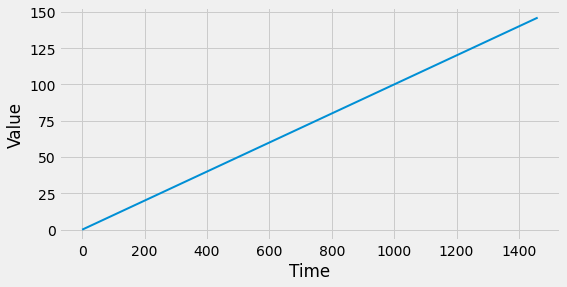

In [20]:
time = np.arange(4 * 365 + 1)
baseline = 10
series = trend(time, 0.1)

plt.figure(figsize=(8, 4))
plot_series(time, series)
plt.show()

In [21]:
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    
    return amplitude * seasonal_pattern(season_time)

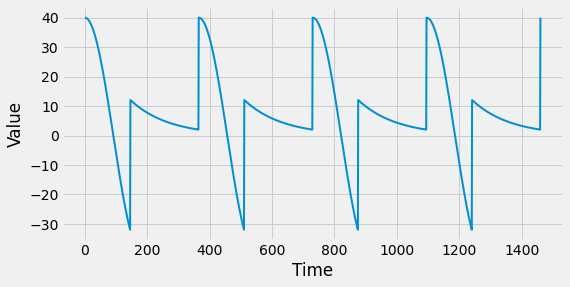

In [22]:
baseline = 10
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(8, 4))
plot_series(time, series)
plt.show()

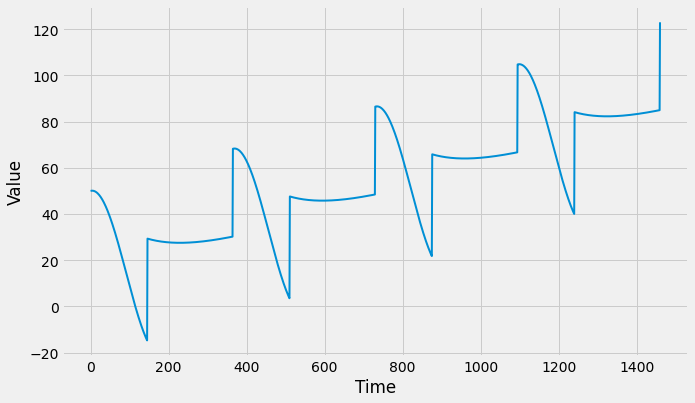

In [23]:
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

### Noise

In [24]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    
    return rnd.randn(len(time)) * noise_level

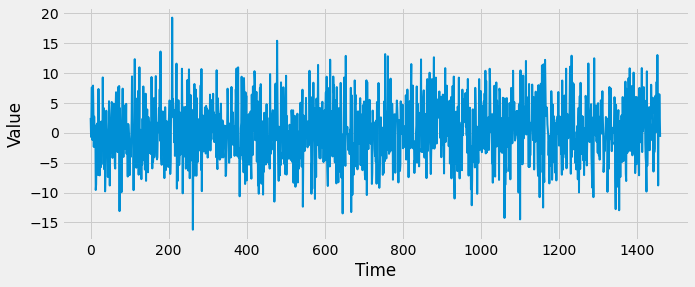

In [26]:
noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 4))
plot_series(time, noise)
plt.show()

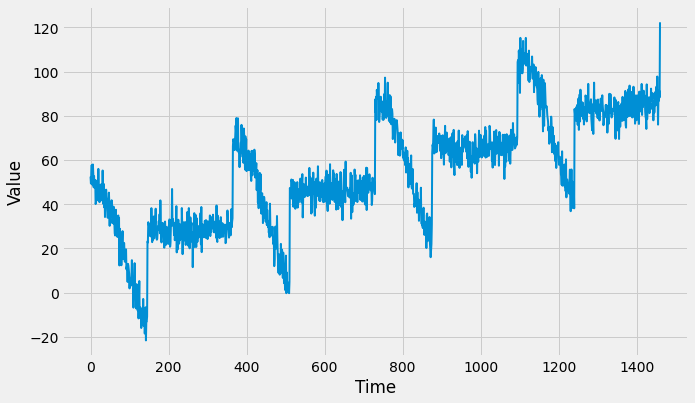

In [27]:
series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [28]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [29]:
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ1 = 0.5
    φ2 = -0.1
    ar = rnd.randn(len(time) + 50)
    ar[:50] = 100
    for step in range(50, len(time) + 50):
        ar[step] += φ1 * ar[step - 50]
        ar[step] += φ2 * ar[step - 33]
        
    return ar[50:] * amplitude

In [30]:
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ = 0.8
    ar = rnd.randn(len(time) + 1)
    for step in range(1, len(time) + 1):
        ar[step] += φ * ar[step - 1]
        
    return ar[1:] * amplitude

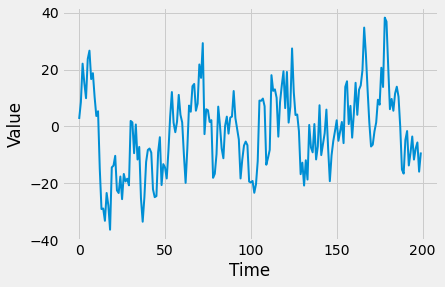

In [31]:
series = autocorrelation(time, 10, seed=42)
plot_series(time[:200], series[:200])
plt.show()

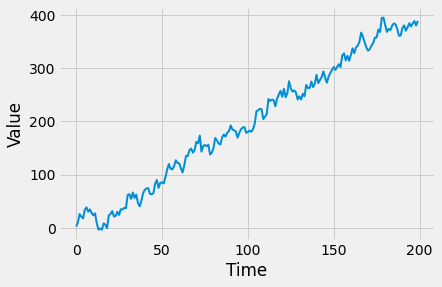

In [32]:
series = autocorrelation(time, 10, seed=42) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

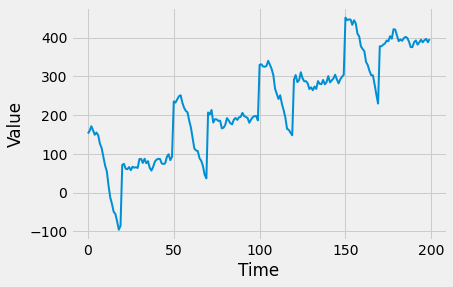

In [33]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

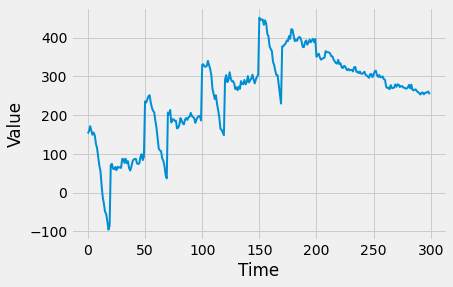

In [34]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
series2 = autocorrelation(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1) + 550
series[200:] = series2[200:]
#series += noise(time, 30)
plot_series(time[:300], series[:300])
plt.show()

In [35]:
def impulses(time, num_impulses, amplitude=1, seed=None):
    rnd = np.random.RandomState(seed)
    impulse_indices = rnd.randint(len(time), size=10)
    series = np.zeros(len(time))
    for index in impulse_indices:
        series[index] += rnd.rand() * amplitude
        
    return series    

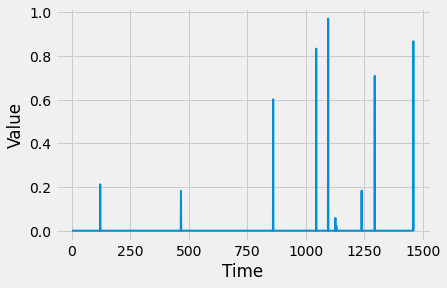

In [36]:
series = impulses(time, 10, seed=42)
plot_series(time, series)
plt.show()

In [37]:
def autocorrelation(source, φs):
    ar = source.copy()
    max_lag = len(φs)
    for step, value in enumerate(source):
        for lag, φ in φs.items():
            if step - lag > 0:
                ar[step] += φ * ar[step - lag]
            
    return ar

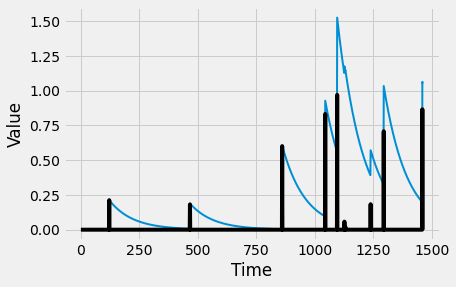

In [38]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.99})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

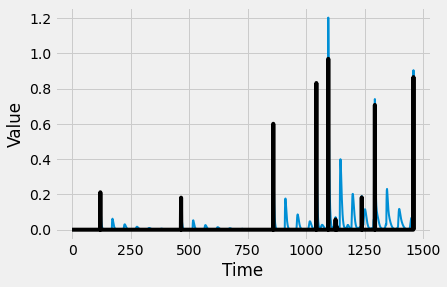

In [39]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.70, 50: 0.2})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

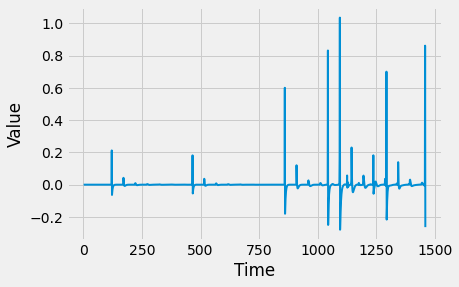

In [40]:
series_diff1 = series[1:] - series[:-1]
plot_series(time[1:], series_diff1)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

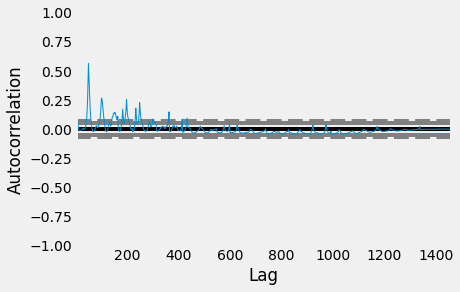

In [42]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series, linewidth=1)

In [45]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1461
Model:                 ARIMA(5, 1, 0)   Log Likelihood                2223.354
Date:                Sun, 27 Jun 2021   AIC                          -4434.708
Time:                        14:16:06   BIC                          -4402.991
Sample:                             0   HQIC                         -4422.876
                               - 1461                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1235      0.009    -13.155      0.000      -0.142      -0.105
ar.L2         -0.1256      0.016     -7.759      0.000      -0.157      -0.094
ar.L3         -0.1091      0.018     -6.160      0.0

In [49]:
df = pd.read_csv("sunspots.csv", parse_dates=["Date"], index_col="Date")
series = df["Monthly Mean Total Sunspot Number"].asfreq("1M")
series.head()

Date
1749-01-31     96.7
1749-02-28    104.3
1749-03-31    116.7
1749-04-30     92.8
1749-05-31    141.7
Freq: M, Name: Monthly Mean Total Sunspot Number, dtype: float64

<AxesSubplot:xlabel='Date'>

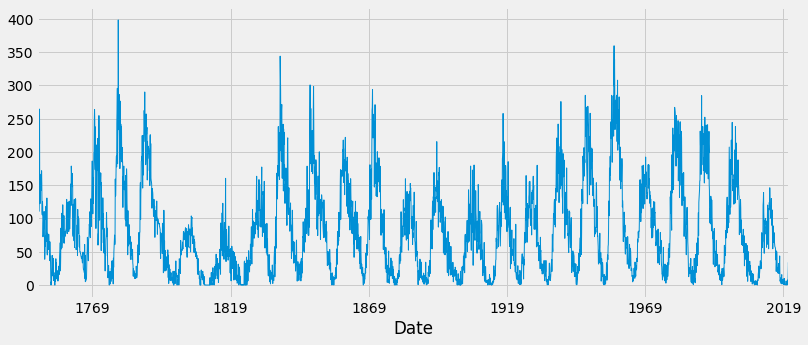

In [52]:
series.plot(figsize=(12, 5), linewidth=1)

<AxesSubplot:xlabel='Date'>

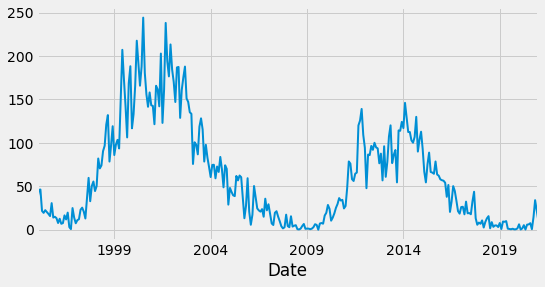

In [56]:
series["1995-01-01":].plot(figsize=(8,4), linewidth=2)

(0.0, 100.0, -50.0, 50.0)

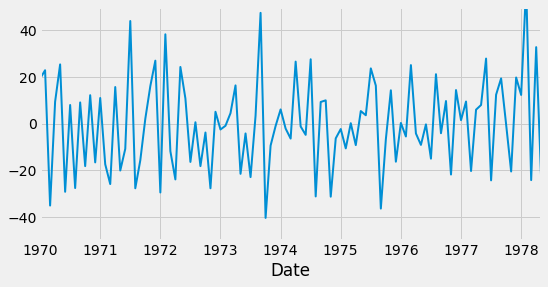

In [58]:
series.diff(1).plot(figsize=(8,4), linewidth=2)
plt.axis([0, 100, -50, 50])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

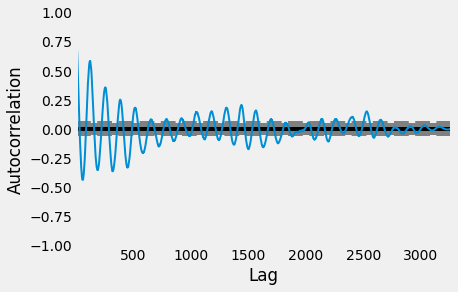

In [61]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series, linewidth=2)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

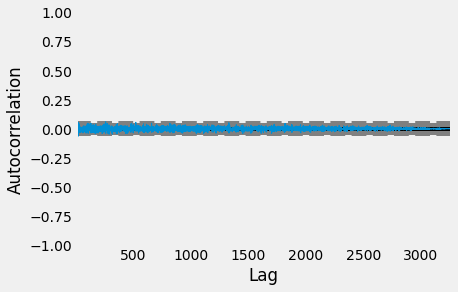

In [63]:
autocorrelation_plot(series.diff(1)[1:], linewidth=1)

(0.0, 500.0, -0.1, 0.1)

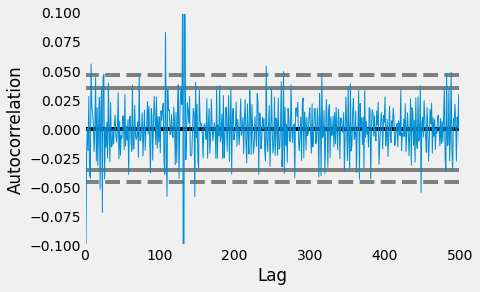

In [65]:
autocorrelation_plot(series.diff(1)[1:].diff(11 * 12)[11*12+1:], linewidth=1)
plt.axis([0, 500, -0.1, 0.1])

(0.0, 50.0, -0.1, 0.1)

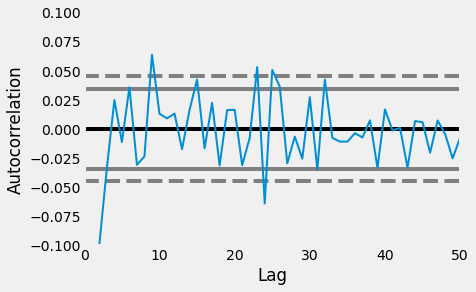

In [68]:
autocorrelation_plot(series.diff(1)[1:], linewidth=2)
plt.axis([0, 50, -0.1, 0.1])

In [69]:
[series.autocorr(lag) for lag in range(1, 50)]

[0.9182467517244699,
 0.8860314675907544,
 0.8700859122855187,
 0.8596131174051874,
 0.8451708761214051,
 0.8325965318271723,
 0.8142618537636366,
 0.8009023400742292,
 0.7914472106297713,
 0.7715964858658894,
 0.7502927205937704,
 0.726884338151892,
 0.701322895306846,
 0.6786429949066952,
 0.6533297890337183,
 0.6210620765307739,
 0.5915480432972883,
 0.5583968547228386,
 0.5303783891321736,
 0.4997651188716434,
 0.4664494790057142,
 0.4382438732744969,
 0.4113361871304737,
 0.3756857991958743,
 0.35060801667185637,
 0.31722994167238716,
 0.27789048176689474,
 0.24342538761999083,
 0.2100571293002743,
 0.1809470701445057,
 0.14732334769300304,
 0.11953585035853213,
 0.08483999797636099,
 0.051416983573674364,
 0.01976698716527696,
 -0.010051035153073628,
 -0.03924592482682628,
 -0.06721901678897518,
 -0.0964207671745006,
 -0.12002061018481741,
 -0.1462012061159967,
 -0.17214652044799056,
 -0.19836293254853693,
 -0.21895351970191293,
 -0.24063743094381804,
 -0.26317525282253396,
 -0.2